### Initial Setup: Installing dependencies, downloading the data and login in the wandb

*Installing and the importing relevant libraries*

In [2]:
!pip install torch torchvision wandb --

In [3]:
# importing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt


*logging into wandb*

In [4]:
wandb.login(key='613aac3388325cb6206db61e3c1a38a707589743')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: da24s006 (da24s006-indian-institue-of-technology-madras-). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

*downloading data*

In [5]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip nature_12K.zip

# import os
# os.listdir('/kaggle/working/')


--2025-04-17 04:46:43--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 172.253.117.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   160MB/s    in 25s     

2025-04-17 04:47:08 (147 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]

Archive:  nature_12K.zip
   creating: inaturalist_12K/
  inflating: inaturalist_12K/.DS_Store  
   creating: inaturalist_12K/train/
   creating: inaturalist_12K/train/Plantae/
  inflating: inaturalist_12K/train/Plantae/1dfc3916ad58af6ce9af9fc8b36ceedd.jpg  
  inflating: inaturalist_12K/train/Plantae/e49eeff2b27ae74351fdf8ffa3791307.jpg  
  inflating: inaturalist_12K/train/Plantae/519ae1c558dff337bb4084934e31a4a8.jpg  


### Question 1: Creating a flexible CNN

In [6]:
class FlexibleCNN(nn.Module):
    
    def __init__(
        self,
        in_channels=3,
        num_classes=10,
        conv_filters=[32, 64, 128, 256, 512],
        kernel_sizes=[3, 3, 3, 3, 3],
        activation_fn_cnn='relu',
        activation_fn_dense='relu',
        dense_neurons=256,
        dropout_p=0.3,
        use_batchnorm=True,
        input_size=224
    ):
        super(FlexibleCNN, self).__init__()
        
        # Activation function mapping
        activation_map = {
            'relu': nn.ReLU,
            'gelu': nn.GELU,
            'silu': nn.SiLU
        }

        self.activation_cnn = activation_map[activation_fn_cnn]()
        self.activation_dense = activation_map[activation_fn_dense]()
        
        # Build conv layers
        layers = []
        prev_channels = in_channels
        for i in range(5):
            padding = kernel_sizes[i] // 2  # Auto-calculate padding
            layers.extend([
                nn.Conv2d(prev_channels, conv_filters[i], 
                         kernel_size=kernel_sizes[i], padding=padding),
                nn.BatchNorm2d(conv_filters[i]) if use_batchnorm else nn.Identity(),
                self.activation_cnn,
                nn.MaxPool2d(2)
            ])
            prev_channels = conv_filters[i]

        # storing convolutoin part in conv
        self.conv = nn.Sequential(*layers)
        
        # Dynamic linear input calculation
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_size, input_size)
            dummy = self.conv(dummy)
            self.flatten_size = dummy.view(1, -1).size(1)

        # storing mlp part in classfier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, dense_neurons),
            self.activation_dense,
            nn.Dropout(dropout_p),
            nn.Linear(dense_neurons, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.classifier(x)


**This is to find the mean and varience or our train data, to normalize the images.**

In [7]:
import os
# Dataset path
data_dir = '/kaggle/working/inaturalist_12K'  # Update this path to your dataset

# Define the basic transform for the dataset (no normalization yet)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load dataset without normalization
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)

# Use DataLoader to compute the mean and std
loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

# Compute the mean and std of the dataset
mean = torch.zeros(3)
std = torch.zeros(3)
for images, _ in loader:
    # Compute mean and std for each channel
    mean += images.mean([0, 2, 3])  # mean for (R, G, B)
    std += images.std([0, 2, 3])   # std for (R, G, B)

mean /= len(loader)
std /= len(loader)

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.4791, 0.4623, 0.3902])
Std: tensor([0.2388, 0.2271, 0.2351])


**now let's use this mean to normalize the data and prepare the data**

In [8]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms (MUST match model's input_size)
input_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4791, 0.4623, 0.3902], [0.2388, 0.2271, 0.2351]) # normalizing with respect to imagenet dataset values
])

test_transform = transforms.Compose([
    transforms.Resize(input_size + 32),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.4791, 0.4623, 0.3902], [0.2388, 0.2271, 0.2351]) # same here
])

# Load dataset
data_dir = '/kaggle/working/inaturalist_12K'  
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transform)

# Stratified validation split
def stratified_split(dataset, val_ratio=0.2):
    targets = np.array([s[1] for s in dataset.samples])
    val_indices = []
    train_indices = []
    for c in np.unique(targets):
        idx = np.where(targets == c)[0]
        np.random.shuffle(idx)
        split = int(len(idx) * (1 - val_ratio))
        train_indices.extend(idx[:split])
        val_indices.extend(idx[split:])
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

train_subset, val_subset = stratified_split(train_dataset)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)


#### first writing training for one epoch

In [9]:

def train_one_epoch(model, loader, optimizer, criterion):
    
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


### let's set up the sweep configuration and write full train function 

In [15]:
sweep_config = {
    'method': 'bayes',
    'name': 'cnn_sweep',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'conv_filters': {
           'values': [
        [32, 64, 128, 256, 512],       # doubing in each subsequent layer
        [64, 128, 256, 512, 512],      # aggressive start
        [32, 32, 64, 64, 128],         # shallow early focus
        [64, 64, 128, 128, 256],       # slow inc filter configuration
        [128, 128, 128, 128, 128],     # constant filter configuration
        [256, 128, 64, 32, 16],        # halving in each subsequent layer
    ]
        },
        'kernel_sizes': {
            'values': [
        [3, 3, 3, 3, 3],           # Standard
        [5, 3, 3, 3, 3],           # Slightly larger receptive field early on
        [3, 5, 3, 5, 3],           # Alternating for varied feature capture
        [7, 5, 3, 3, 3],           # Very large first kernel, good for coarse features
    ]
        },
        'activation_fn_cnn': {'values': ['relu', 'gelu', 'silu']},
        'epochs': {'values': [5, 10]},
        'activation_fn_dense': {'values': ['relu', 'gelu', 'silu']},
        'dense_neurons': {'values': [64, 128, 256, 512]},
        'dropout_p': {'values': [0.2, 0.3]},
        'use_batchnorm': {'values': [True, False]},
        'lr': {'values': [1e-3, 5e-4]},
    }
}

def train_model():
    
    wandb.init()
    config = wandb.config
    run_name = f"F:{config.conv_filters}_K:{config.kernel_sizes}_Acnn:{config.activation_fn_cnn}_Adense:{config.activation_fn_dense}_D:{config.dropout_p}_B:{config.use_batchnorm}_LR:{config.lr}_E:{config.epochs}"
    wandb.run.name = run_name  # Set descriptive name for this run
    
    model = FlexibleCNN(
        conv_filters=config.conv_filters,
        kernel_sizes=config.kernel_sizes,
        activation_fn_cnn=config.activation_fn_cnn,
        activation_fn_dense=config.activation_fn_dense,
        dense_neurons=config.dense_neurons,
        dropout_p=config.dropout_p,
        use_batchnorm=config.use_batchnorm,
        input_size=input_size  # Critical for shape matching
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0.0
    for epoch in range(config.epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model_version_2.pth')
    
    wandb.finish()


#### initiating the sweep 

In [ ]:
# Initialize sweep
wandb.login()
sweep_id = wandb.sweep(sweep_config, project="iNaturalist-CNN")

# Run 20 experiments (adjust count as needed)
wandb.agent(sweep_id, train_model, count=30)


**Since the session has got time out after a big run i am not able to see the best model in the working directory, so i've trained the model again just once by manually setting the hyper parameters with best validation accuracy form the parallel plot of wandb**

To verify look here: [https://wandb.ai/da24s006-indian-institue-of-technology-madras-/iNaturalist-CNN/sweeps/g4wjwz50?nw=nwuserda24s006](http://)

In [10]:
# commnting out wandb 

def train_model():
    
    # wandb.init()
    # config = wandb.config
    # run_name = f"F:{config.conv_filters}_K:{config.kernel_sizes}_Acnn:{config.activation_fn_cnn}_Adense:{config.activation_fn_dense}_D:{config.dropout_p}_B:{config.use_batchnorm}_LR:{config.lr}_E:{config.epochs}"
    # wandb.run.name = run_name  # Set descriptive name for this run
    
    model = FlexibleCNN(
        conv_filters=[256, 128, 64, 32, 16],
        kernel_sizes=[3, 5, 3, 5, 3],
        activation_fn_cnn='silu',
        activation_fn_dense='silu',
        dense_neurons=128,
        dropout_p=0.3,
        use_batchnorm=False,
        input_size=input_size  # Critical for shape matching
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()
    
    # best_val_acc = 0.0
    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        # wandb.log({
        #     "epoch": epoch,
        #     "train_loss": train_loss,
        #     "train_acc": train_acc,
        #     "val_loss": val_loss,
        #     "val_acc": val_acc
        # })
        
        # saving the best model 
        torch.save(model.state_dict(), 'best_model_wandb_config.pth')
    
    # wandb.finish()


# calling train_model now by manually setting the best set of param saving that
train_model()


**now let's use best_model_wandb_config.pth and run it on test data**

In [13]:
# defining the best model 
best_model = FlexibleCNN(
        conv_filters=[256, 128, 64, 32, 16],
        kernel_sizes=[3, 5, 3, 5, 3],
        activation_fn_cnn='silu',
        activation_fn_dense='silu',
        dense_neurons=128,
        dropout_p=0.3,
        use_batchnorm=False,
        input_size=input_size  # Critical for shape matching
    ).to(device)

# Load the state dict from the saved model checkpoint with weights_only=True
checkpoint = torch.load('best_model_wandb_config.pth', weights_only=True)

# Modify the state_dict to only load the matching parameters
model_state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

# Match the layers between the checkpoint and the current model configuration
model_state_dict = {k: v for k, v in model_state_dict.items() if k in best_model.state_dict() and v.shape == best_model.state_dict()[k].shape}

# Load the matching state_dict into the model with strict=False to allow for missing keys
best_model.load_state_dict(model_state_dict, strict=False)

# Set the model to evaluation mode
best_model.eval()

# Evaluate on the test set
test_loss, test_acc = validate(best_model, test_loader, nn.CrossEntropyLoss())
print(f"Test Accuracy: {test_acc*100:.2f}%")


Test Accuracy: 37.15%


#### Test Accuracy = 37.15%
*/kaggle/workingbest_model_wandb_config.pth* is already upload on the github repo pls use it if you want to verify

*/kaggle/workingbest_model_wandb_config.pth* is already upload on the github repo pls use it if you want to verify

#### now let's visualize

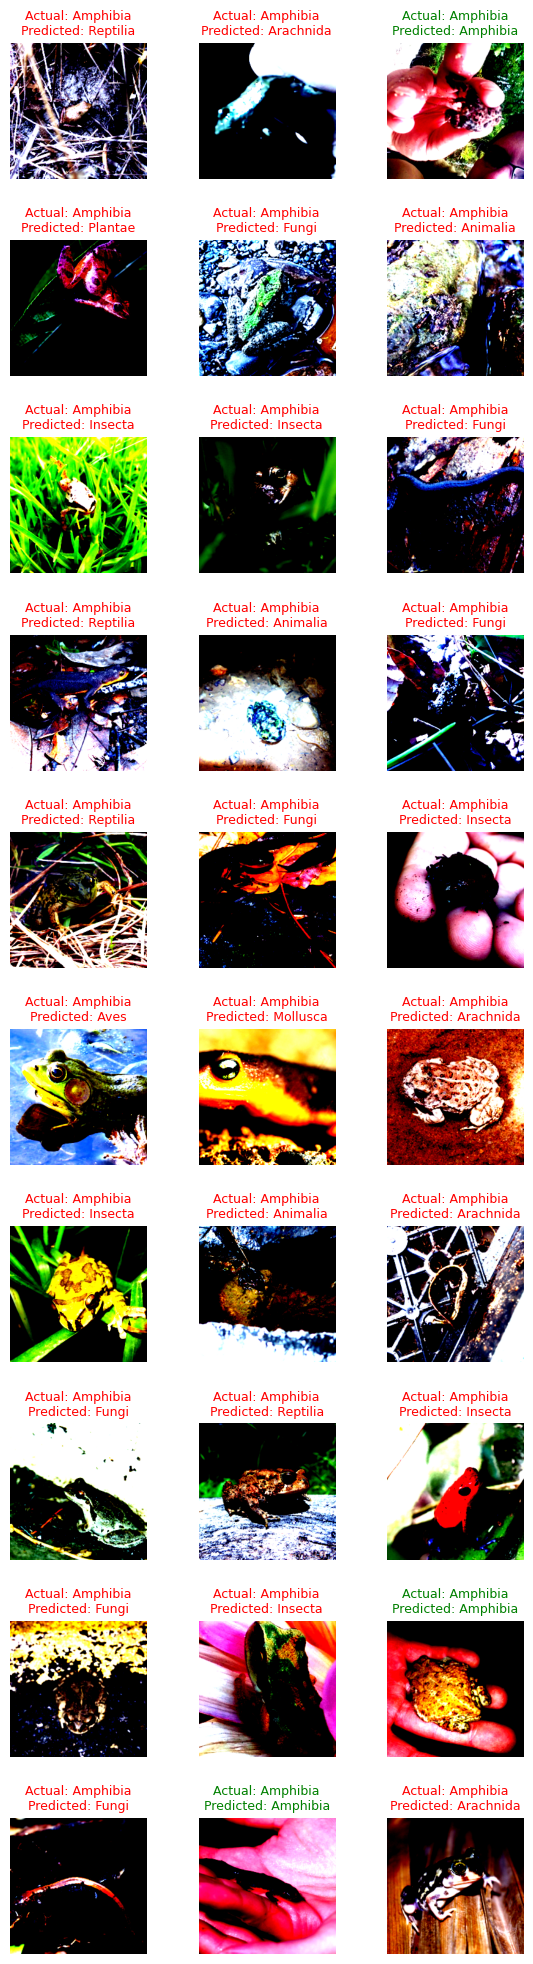

In [17]:
import matplotlib.pyplot as plt

def show_predictions_grid(model, test_loader, device):
    model.eval()
    class_names = test_loader.dataset.classes
    images_shown = 0
    total_images = 30

    fig, axes = plt.subplots(10, 3, figsize=(6, 20))
    axes = axes.flatten()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= total_images:
                    fig.tight_layout(pad=2.0)
                    plt.show()
                    return

                img = images[i].cpu().permute(1, 2, 0)
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                color = 'green' if true_label == pred_label else 'red'

                ax = axes[images_shown]
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"Actual: {true_label}\nPredicted: {pred_label}", fontsize=9, color=color)

                images_shown += 1

show_predictions_grid(best_model, test_loader, device=device)